# tRNA Example Using the iJL1678b ECOLIme Model: Glycine

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',150)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Solve the model

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

In [4]:
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 61.636477 seconds
Finished substituting S,lb,ub in 4.644235 seconds
Finished makeME_LP in 0.795715 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 4.208421 seconds
Finished makeME_LP in 0.730862 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 4.055989 seconds
Finished makeME_LP in 0.732830 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 4.072925 seconds
Finished makeME_LP in 0.722859 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 4.057408 seconds
Finished makeME_LP in 0.728063 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 4.095946 seconds
Finished makeME_LP in 0.738576 seconds
Getting MINOS pa

## 4. Modeling the ECOLIme iJL1678b Glycine tRNA Production Process

The iJL1678b ME model has the following pathway for the biosythesis of tRNA.

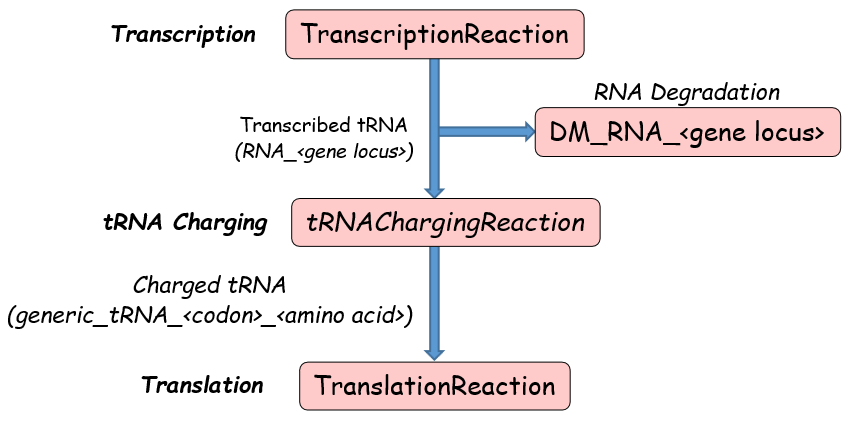

For this and all COBRAme models the tRNA metabolite *(RNA_gene locus)* produced by the transcription reaction is a reactant in one or more tRNA Charging reactions *(tRNAChargingReaction).* These charging reactions include all the tRNA modifications required for each tRNA metabolite. The product of this reaction is a charged tRNA metabolite *(generic_tRNA_codon_amino acid)* that is identified by it's codon and amino acid metabolite.

To explore the detail of this pathway let's begin by looking for the specific reactions and metabolites required for the synthesis of charged glycine tRNA. 

Since the COBRAme model does not include a "gene" class, the genes producing the glycine tRNA can be found by looking at the amino_acid category of the tRNAData information in the process_data class. If the amino_acid category is "gly_c" the id of that process data information can be determined. With that id the RNA information can be determined. The id of the unprocessed tRNA metabolites produced by the transcription reactions includes the gene name which is represented by it's locus number (e.g. RNA_"gene locus number"). 

In [5]:
glycine_tRNA_1 = []
glycine_tRNA_genes_1 = []
x = [r.id for r in me.process_data if type(r) == cobrame.tRNAData]
for r in x:
    if me.process_data.get_by_id(r).amino_acid == 'gly_c': # Identify the glyc_c amino acids
        y1 = me.process_data.get_by_id(r).RNA # Identify the RNA associated with the gly_c amino acids
        y2 = y1.replace('RNA_','') # Identify the genes associated with the gly_c amino acids are part of the RNA names
        glycine_tRNA_1.append(y1)
        glycine_tRNA_genes_1.append(y2)
glycine_tRNA = [*set(glycine_tRNA_1)] # Remove duplicates
glycine_tRNA.sort() # Sort the list
glycine_tRNA_genes = [*set(glycine_tRNA_genes_1)] # Remove duplicates
glycine_tRNA_genes.sort() # Sort the list
print('\nGlycine tRNA Genes = ', glycine_tRNA_genes)
print('\nGlycine tRNA RNA = ', glycine_tRNA)


Glycine tRNA Genes =  ['b1911', 'b2864', 'b3978', 'b4163', 'b4164', 'b4165']

Glycine tRNA RNA =  ['RNA_b1911', 'RNA_b2864', 'RNA_b3978', 'RNA_b4163', 'RNA_b4164', 'RNA_b4165']


Find the names of the charged glycine tRNA metabolites in the iJL1678b model.

In [6]:
glycine_charged_tRNA = []
met = [r.id for r in me.metabolites]
for m in met:
    if "gly_c"in m and "tRNA" in m:
        glycine_charged_tRNA.append(m)
glycine_charged_tRNA

['generic_tRNA_GGC_gly_c',
 'generic_tRNA_GGU_gly_c',
 'generic_tRNA_GGG_gly_c',
 'generic_tRNA_GGA_gly_c']

Find the reactions that produce these charged glycine tRNA metabolites. For these metabolites we can search the products of all the model's reactions to find the tRNA charging reactions that produce these charged tRNA glycine metabolites.

In [7]:
rxn = [r.id for r in me.reactions]
charging_tRNA_reactions = []
for y in range(len(glycine_charged_tRNA)):
    for r in rxn:
        rxn_products = [r.id for r in me.reactions.get_by_id(r).products]
        for x in range(len(rxn_products)):
            if rxn_products[x] == glycine_charged_tRNA[y]:
                charging_tRNA_reactions.append(r)
charging_tRNA_reactions.sort()
charging_tRNA_reactions

['charging_tRNA_b1911_GGC',
 'charging_tRNA_b1911_GGU',
 'charging_tRNA_b2864_GGG',
 'charging_tRNA_b3978_GGA',
 'charging_tRNA_b4163_GGC',
 'charging_tRNA_b4163_GGU',
 'charging_tRNA_b4164_GGC',
 'charging_tRNA_b4164_GGU',
 'charging_tRNA_b4165_GGC',
 'charging_tRNA_b4165_GGU']

Create a list of the glycine tRNA transcription reactions, degradation reactions, charging reactions and charged metabolites?

In [8]:
charged_tRNA = []
degradation_reactions = []
transcription_reactions = []
charging_reactions = []

for rna in glycine_tRNA:
    rxn = [r.id for r in me.reactions]
    degradation_reactions_list = []
    transcription_reactions_list = []
    charging_reactions_list = []
    for r in rxn:
        react = [r.id for r in me.reactions.get_by_id(r).reactants]
        prod = [r.id for r in me.reactions.get_by_id(r).products]
        if rna in react:
            if "DM_" in r:
                degradation_reactions_list.append(r)
            else:
                charging_reactions_list.append(r)
        if rna in prod:
            transcription_reactions_list.append(r)

    degradation_reactions.append(degradation_reactions_list)
    charging_reactions.append(charging_reactions_list)
    transcription_reactions.append(transcription_reactions_list)
    
    charged_tRNA_list = []
    for i in range(len(charging_reactions_list)):
        for j in glycine_charged_tRNA:
            prod = [r.id for r in me.reactions.get_by_id(charging_reactions_list[i]).products]
            if j in prod:
                charged_tRNA_list.append(j)
    
    charged_tRNA.append(charged_tRNA_list)

### Table of the Combined tRNA Reactions and Metabolites

Create a table showing the glycine tRNA biosynthesis metabolites and reactions? 

In [9]:
glycine_RNA_minimized = list(set(glycine_tRNA))
glycine_RNA_minimized.sort()
glycine_RNA_minimized

# Create Pandas table
zipped = list(zip(glycine_tRNA_genes, transcription_reactions, glycine_RNA_minimized, degradation_reactions, charging_reactions, charged_tRNA))
df = pd.DataFrame(zipped, columns=['tRNA Gene', 'tRNA Transcription Reactions', 'RNA Metabolites', 
                                   'Degradation Reactions', 'Charging Reactions', 'Charged tRNA Metabolites']).set_index('tRNA Gene')
df

,tRNA Transcription Reactions,RNA Metabolites,Degradation Reactions,Charging Reactions,Charged tRNA Metabolites
tRNA Gene,,,,,
b1911,[transcription_TU00512_from_RpoD_mono],RNA_b1911,[DM_RNA_b1911],"[charging_tRNA_b1911_GGC, charging_tRNA_b1911_GGU]","[generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c]"
b2864,"[transcription_TU0_13770_from_RpoD_mono, transcription_TU00516_from_RpoD_mono]",RNA_b2864,[DM_RNA_b2864],[charging_tRNA_b2864_GGG],[generic_tRNA_GGG_gly_c]
b3978,[transcription_TU00504_from_RpoD_mono],RNA_b3978,[DM_RNA_b3978],[charging_tRNA_b3978_GGA],[generic_tRNA_GGA_gly_c]
b4163,[transcription_TU00505_from_RpoD_mono],RNA_b4163,[DM_RNA_b4163],"[charging_tRNA_b4163_GGC, charging_tRNA_b4163_GGU]","[generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c]"
b4164,[transcription_TU00505_from_RpoD_mono],RNA_b4164,[DM_RNA_b4164],"[charging_tRNA_b4164_GGC, charging_tRNA_b4164_GGU]","[generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c]"
b4165,[transcription_TU00505_from_RpoD_mono],RNA_b4165,[DM_RNA_b4165],"[charging_tRNA_b4165_GGC, charging_tRNA_b4165_GGU]","[generic_tRNA_GGC_gly_c, generic_tRNA_GGU_gly_c]"


## Find the flux through the tRNA reactions

This data can be found in the "transcription_reactions" and "charging_reactions" variables.

In [10]:
import itertools
transcription_reactions_flux = []
charging_reactions_flux = []
i = 0
for r in itertools.chain(*transcription_reactions):
    transcription_reactions_flux.append(me.reactions.get_by_id(r).x)
    i += 1

i = 0
for r in itertools.chain(*charging_reactions):
    charging_reactions_flux.append(me.reactions.get_by_id(r).x)
    i += 1
      
# Create Pandas table
transcription_reactions2 = [r for r in itertools.chain(*transcription_reactions)]
charging_reactions2 = [r for r in itertools.chain(*charging_reactions)]

zipped1 = list(zip(transcription_reactions2, transcription_reactions_flux))
df_flux1 = pd.DataFrame(zipped1, columns=['Transcription Reactions', 'Transcription Reactions Flux'])

zipped2 = list(zip(charging_reactions2, charging_reactions_flux))
df_flux2 = pd.DataFrame(zipped2, columns=['Charging Reactions', 'Charging Reactions Flux'])

df_flux = pd.concat([df_flux1,df_flux2],axis=1)
df_flux

,Transcription Reactions,Transcription Reactions Flux,Charging Reactions,Charging Reactions Flux
0,transcription_TU00512_from_RpoD_mono,0.000006,charging_tRNA_b1911_GGC,0.044674
1,transcription_TU0_13770_from_RpoD_mono,0.000005,charging_tRNA_b1911_GGU,0.000000
2,transcription_TU00516_from_RpoD_mono,0.000000,charging_tRNA_b2864_GGG,0.033864
3,transcription_TU00504_from_RpoD_mono,0.000003,charging_tRNA_b3978_GGA,0.022934
4,transcription_TU00505_from_RpoD_mono,0.000012,charging_tRNA_b4163_GGC,0.019518
5,transcription_TU00505_from_RpoD_mono,0.000012,charging_tRNA_b4163_GGU,0.066318
6,transcription_TU00505_from_RpoD_mono,0.000012,charging_tRNA_b4164_GGC,0.000000
7,NaN,NaN,charging_tRNA_b4164_GGU,0.085836
8,NaN,NaN,charging_tRNA_b4165_GGC,0.085836
9,NaN,NaN,charging_tRNA_b4165_GGU,0.000000


### Find the ratio of glycine codon utilization

In [11]:
# GGC codons
GGC_1 = me.reactions.get_by_id('charging_tRNA_b1911_GGC').x
GGC_2 = me.reactions.get_by_id('charging_tRNA_b4163_GGC').x
GGC_3 = me.reactions.get_by_id('charging_tRNA_b4164_GGC').x
GGC_4 = me.reactions.get_by_id('charging_tRNA_b4165_GGC').x
GGC_total = GGC_1  + GGC_2 + GGC_3 + GGC_4 

# GGU codons
GGU_1 = me.reactions.get_by_id('charging_tRNA_b1911_GGU').x
GGU_2 = me.reactions.get_by_id('charging_tRNA_b4163_GGU').x
GGU_3 = me.reactions.get_by_id('charging_tRNA_b4164_GGU').x
GGU_4 = me.reactions.get_by_id('charging_tRNA_b4165_GGU').x
GGU_total = GGU_1  + GGU_2 + GGU_3 + GGU_4 

# GGG codons
GGG_total = me.reactions.get_by_id('charging_tRNA_b2864_GGG').x

# GGA codons
GGA_total = me.reactions.get_by_id('charging_tRNA_b3978_GGA').x

# Total tRNA flux
glycine_tRNA_total_flux = GGC_total  + GGU_total + GGG_total + GGA_total 

# Codon ratios

GGC_ratio = GGC_total/glycine_tRNA_total_flux
GGU_ratio = GGU_total/glycine_tRNA_total_flux
GGG_ratio = GGG_total/glycine_tRNA_total_flux
GGA_ratio = GGA_total/glycine_tRNA_total_flux

print(' GGC_ratio: ', GGC_ratio, '\n GGU_ratio: ', GGU_ratio, "\n GGG_ratio: ", GGG_ratio, '\n GGA_ratio: ', GGA_ratio)

test = GGC_ratio + GGU_ratio+ GGG_ratio + GGA_ratio
test

 GGC_ratio:  0.41792812878966074 
 GGU_ratio:  0.4238512701226854 
 GGG_ratio:  0.09433500959902502 
 GGA_ratio:  0.06388559148862866


0.9999999999999998

## Find the supporting reactions for charging glycine tRNA

### Find the metabolites required by the tRNA charging reactions

In [12]:
glycine_charging_metabolites = []
charging_metabolites = []
mets = []

rxn = [r for r in itertools.chain(*charging_reactions)] # Glycine charging reactions
for r in rxn: # Find the metabolites required for the charging reactions
    react = [r.id for r in me.reactions.get_by_id(r).reactants]
    charging_metabolites.append(react)

glycine_charging_metabolites = set([r for r in itertools.chain(*charging_metabolites)]) # Remove duplicates

for m in set(glycine_tRNA): # Remove the tRNA RNA metabolites
    glycine_charging_metabolites.remove(m)
    
for r in glycine_charging_metabolites:  # Identify the supporting metabolites  
    if "_c" in r:
        mets.append(r)
        
for m in mets: # Remove the supporting metabolites
    glycine_charging_metabolites.remove(m)

print('The metabolites required by the charging reactions')
glycine_charging_metabolites

The metabolites required by the charging reactions


{'Gly_RS_tetra',
 'IscS_mod_2:pydx5p_mod_1:SH',
 'ThiI_mono',
 'TrmA_mono',
 'TruB_mono',
 'YggH_mono',
 'generic_Dus'}

### Find the reactions that produce the charging reaction reactants

In [13]:
glycine_support_reactions = []
glycine_support_metabolites = []

for m in glycine_charging_metabolites:
    for r in [r.id for r in me.reactions]:
        if m in [r.id for r in me.reactions.get_by_id(r).products]:
            glycine_support_reactions.append(r)
            glycine_support_metabolites.append(m)

glycine_support_reactions 

['DusA_mono_to_generic_Dus',
 'DusB_mono_to_generic_Dus',
 'DusC_mono_to_generic_Dus',
 'formation_ThiI_mono',
 'formation_TruB_mono',
 'ICYSDS1_FWD_CPLX_dummy',
 'formation_TrmA_mono',
 'formation_YggH_mono',
 'formation_Gly_RS_tetra']

The function of these glyucine tRNA modifications are

- 'ThiI_mono'- tRNA uridine 4-sulfurtransferase
- 'Gly_RS_tetra'- Glycine—tRNA ligase
- 'generic_Dus'- tRNA-dihydrouridine synthase A
- 'generic_Dus'- tRNA-dihydrouridine synthase B
- 'generic_Dus'- tRNA-dihydrouridine synthase C
- 'YggH_mono'- tRNA m<sup>7</sup>G46 methyltransferase (also TrmB)
- 'TruB_mono'- tRNA pseudouridine<sup>55</sup> synthase
- 'IscS_mod_2:pydx5p_mod_1:SH'- cysteine desulfurase IscS
- 'TrmA_mono'- tRNA m<sup>5</sup>U54 methyltransferase

Below is a diagram showing all the tRNA modification for glycine tRNA gene b4165

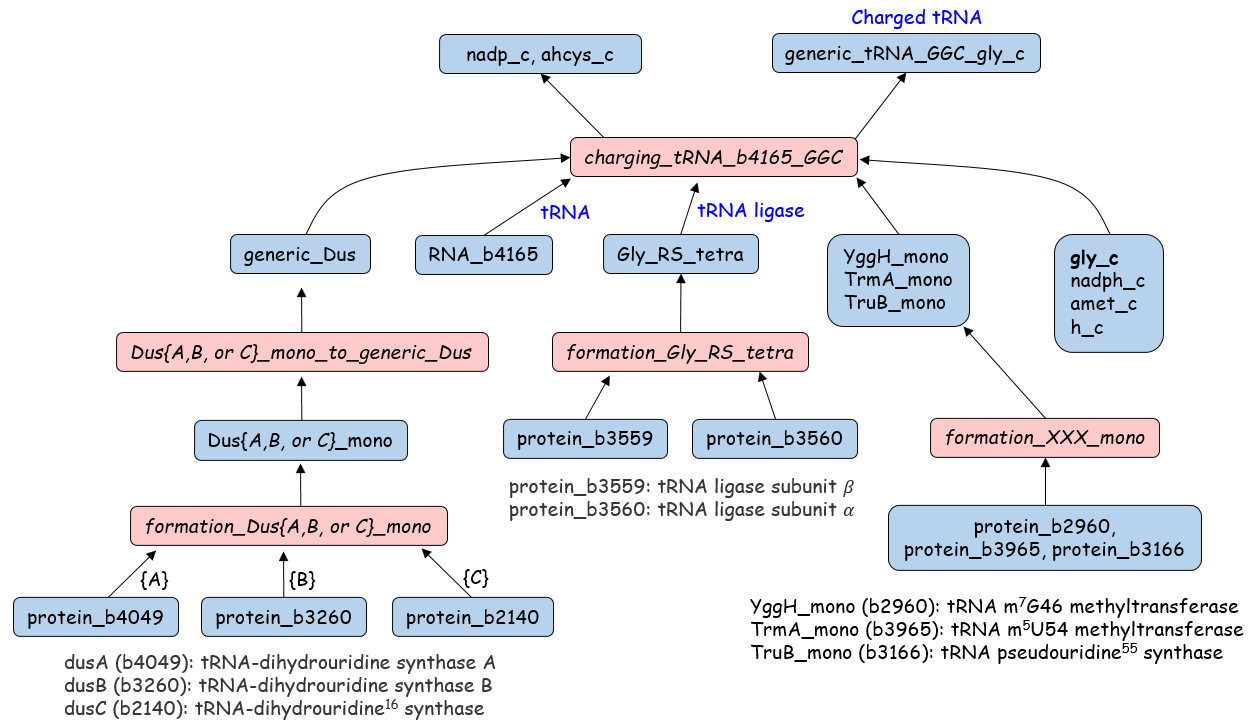

### Find the fluxes of the reactions that produce the charging reaction reactants

In [14]:
modifications = ['tRNA uridine 4-sulfurtransferase','tRNA-dihydrouridine synthase A', 
                 'Glycine—tRNA ligase', 'tRNA-dihydrouridine synthase B', 
                 'tRNA-dihydrouridine synthase C', 'tRNA m7G46 methyltransferase', 
                'tRNA pseudouridine55 synthase', 'cysteine desulfurase IscS',
                'tRNA m5U54 methyltransferase']

supporting_charging_reactions_flux = []

for r in glycine_support_reactions:
    supporting_charging_reactions_flux.append(me.reactions.get_by_id(r).x)

zipped = list(zip(glycine_support_metabolites, glycine_support_reactions, 
                  modifications, supporting_charging_reactions_flux))
df_flux = pd.DataFrame(zipped, columns=['Glycine Support Metabolites', 'Glycine Support Reactions', 
                                        'tRNA Modifications', 'Glycine Support Reactions Flux'])
df_flux

,Glycine Support Metabolites,Glycine Support Reactions,tRNA Modifications,Glycine Support Reactions Flux
0,generic_Dus,DusA_mono_to_generic_Dus,tRNA uridine 4-sulfurtransferase,0.000000e+00
1,generic_Dus,DusB_mono_to_generic_Dus,tRNA-dihydrouridine synthase A,0.000000e+00
2,generic_Dus,DusC_mono_to_generic_Dus,Glycine—tRNA ligase,4.679154e-09
3,ThiI_mono,formation_ThiI_mono,tRNA-dihydrouridine synthase B,1.130280e-09
4,TruB_mono,formation_TruB_mono,tRNA-dihydrouridine synthase C,2.339411e-09
5,IscS_mod_2:pydx5p_mod_1:SH,ICYSDS1_FWD_CPLX_dummy,tRNA m7G46 methyltransferase,1.060364e-03
6,TrmA_mono,formation_TrmA_mono,tRNA pseudouridine55 synthase,2.284456e-09
7,YggH_mono,formation_YggH_mono,cysteine desulfurase IscS,1.635159e-09
8,Gly_RS_tetra,formation_Gly_RS_tetra,tRNA m5U54 methyltransferase,1.270606e-06


The locations of these RNA modifications can be see in the following figure.

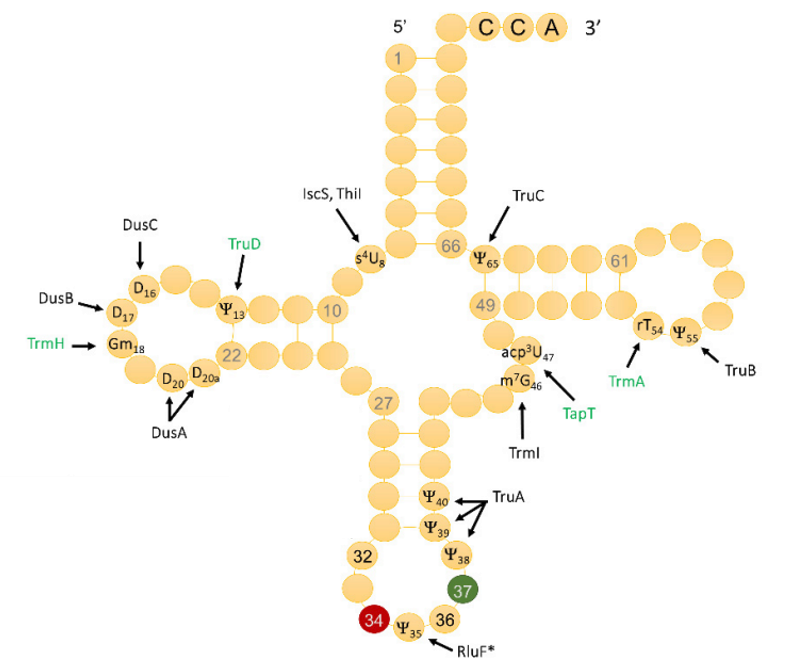

The figure is from de Crecy-Lagard, Valerie, et al. "Survey and validation of tRNA modifications and their corresponding genes in Bacillus subtilis sp subtilis strain 168." Biomolecules 10.7 (2020): 977.

Not all of the charging reactions have the same modification metabolites as seen below.

In [15]:
pd.set_option('display.max_colwidth',150)

zipped = list(zip(charging_tRNA_reactions, charging_metabolites))
df_modifications = pd.DataFrame(zipped, columns=['tRNA Charging Reactions', 'Modification Metabolites'])
df_modifications

,tRNA Charging Reactions,Modification Metabolites
0,charging_tRNA_b1911_GGC,"[RNA_b1911, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
1,charging_tRNA_b1911_GGU,"[RNA_b1911, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
2,charging_tRNA_b2864_GGG,"[RNA_b2864, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, TrmA_mono, amet_c, TruB_mono, ThiI_mono, IscS_mod_2:pydx5p_mod_1:SH, atp_c]"
3,charging_tRNA_b3978_GGA,"[RNA_b3978, gly_c, Gly_RS_tetra, TrmA_mono, amet_c, TruB_mono]"
4,charging_tRNA_b4163_GGC,"[RNA_b4163, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
5,charging_tRNA_b4163_GGU,"[RNA_b4163, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
6,charging_tRNA_b4164_GGC,"[RNA_b4164, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
7,charging_tRNA_b4164_GGU,"[RNA_b4164, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
8,charging_tRNA_b4165_GGC,"[RNA_b4165, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"
9,charging_tRNA_b4165_GGU,"[RNA_b4165, gly_c, Gly_RS_tetra, generic_Dus, nadph_c, h_c, YggH_mono, amet_c, TrmA_mono, TruB_mono]"


### Proteins required to create modification metabolites

Find the proteins that create the modification metabolites

In [16]:
[r.id for r in me.reactions.get_by_id('formation_DusA_mono').reactants]

['protein_b4049']

In [17]:
[r.id for r in me.reactions.get_by_id('formation_DusB_mono').reactants]

['protein_b3260']

In [18]:
[r.id for r in me.reactions.get_by_id('formation_DusC_mono').reactants]

['protein_b2140']

In [19]:
[r.id for r in me.reactions.get_by_id('formation_Gly_RS_tetra').reactants]

['protein_b3559', 'protein_b3560']

In [20]:
me.reactions.get_by_id('formation_Gly_RS_tetra').reaction

'2.0 protein_b3559 + 2.0 protein_b3560 --> Gly_RS_tetra'

In [21]:
[r.id for r in me.reactions.get_by_id('formation_YggH_mono').reactants]

['protein_b2960']

In [22]:
[r.id for r in me.reactions.get_by_id('formation_TrmA_mono').reactants]

['protein_b3965']

In [23]:
[r.id for r in me.reactions.get_by_id('formation_TruB_mono').reactants]

['protein_b3166']